# 4 different ways to predict survival on Titanic

These are my notes from various blogs to find different ways to predict survival on Titanic using Python-stack. I am interested to compare different attempts the [kaggle competition](https://www.kaggle.com/c/titanic). 
I am going to compare and contrast different analysis to find similarity and difference in approaches to predict survival on Titanic.

This Notebook will show basic examples of:

* Data Handling
    * Importing Data with Pandas
    * Cleaning Data
    * Exploring Data through Visualizations with Matplotlib

* Data Analysis
    * Supervised Machine learning Techniques:
        * Logit Regression Model
        * Plotting results
        * Support Vector Machine (SVM) using 3 kernels
        * Basic Random Forest
        * Plotting results
        * etc..
* Valuation of the Analysis
    * K-folds cross validation to valuate results locally
    * Output the results from the Notebook to Kaggle
  

### Columns Information
* The Survived column is the target variable. If Suvival = 1 the passenger survived, otherwise he's dead.

* The other variables that describe the passengers are:
    
    * PassengerId: and id given to each traveler on the boat
    * Pclass: the passenger class. It has three possible values: 1,2,3
    * The Name
    * The Sex
    * The Age
    * SibSp: number of siblings and spouses traveling with the passenger
    * Parch: number of parents and children traveling with the passenger
    * The ticket number
    * The ticket Fare
    * The cabin number
    * The embarkation. It has three possible values S,C,Q

## 1. Way to predict survival on Titianic
These notes are taken from this [link](https://habrahabr.ru/post/274171/)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\Titanic\train.csv")
test_data = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\Titanic\test.csv")

In [3]:
#Putting the two samples (train-sample and test-sample) in a total all-sampled.
all_data = pd.concat([train_data, test_data])


Why do it, because in the test-sample there is survival field missing? 
The total sample is useful for calculating the statistics for all the other fields (mean, median, quantile, minima and maxima), as well as connections between these fields. 


### Data analysis

In [4]:
print("===== survived by class and sex")
print(train_data.groupby(["Pclass", "Sex"])["Survived"].value_counts(normalize=True))

===== survived by class and sex
Pclass  Sex     Survived
1       female  1           0.968085
                0           0.031915
        male    0           0.631148
                1           0.368852
2       female  1           0.921053
                0           0.078947
        male    0           0.842593
                1           0.157407
3       female  0           0.500000
                1           0.500000
        male    0           0.864553
                1           0.135447
dtype: float64


We see that the boat has more survivors as women - the women chance of survival rate is 96.8%, 92.1% and 50% depending on the class of ticket. The chance of surviving men is less, respectively, 36.9%, 15.7% and 13.5%. 

In [5]:
describe_fields = ["Age", "Fare", "Pclass", "SibSp", "Parch"]

print("===== train: males")
print(train_data[train_data["Sex"] == "male"][describe_fields].describe())

print("===== test: males")
print(test_data[test_data["Sex"] == "male"][describe_fields].describe())

print("===== train: females")
print(train_data[train_data["Sex"] == "female"][describe_fields].describe())

print("===== test: females")
print(test_data[test_data["Sex"] == "female"][describe_fields].describe())

===== train: males
              Age        Fare      Pclass       SibSp       Parch
count  453.000000  577.000000  577.000000  577.000000  577.000000
mean    30.726645   25.523893    2.389948    0.429809    0.235702
std     14.678201   43.138263    0.813580    1.061811    0.612294
min      0.420000    0.000000    1.000000    0.000000    0.000000
25%     21.000000    7.895800    2.000000    0.000000    0.000000
50%     29.000000   10.500000    3.000000    0.000000    0.000000
75%     39.000000   26.550000    3.000000    0.000000    0.000000
max     80.000000  512.329200    3.000000    8.000000    5.000000
===== test: males
              Age        Fare      Pclass       SibSp       Parch
count  205.000000  265.000000  266.000000  266.000000  266.000000
mean    30.272732   27.527877    2.334586    0.379699    0.274436
std     13.389528   41.079423    0.808497    0.843735    0.883745
min      0.330000    0.000000    1.000000    0.000000    0.000000
25%     22.000000    7.854200    2.0000

### Putting a small digest of the full sample - it will be necessary to continue the conversion samples.

In [6]:
import re
class DataDigest:

    def __init__(self):
        self.ages = None
        self.fares = None
        self.titles = None
        self.cabins = None
        self.families = None
        self.tickets = None

def get_title(name):
    if pd.isnull(name):
        return "Null"

    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1).lower()
    else:
        return "None"


def get_family(row):
    last_name = row["Name"].split(",")[0]
    if last_name:
        family_size = 1 + row["Parch"] + row["SibSp"]
        if family_size > 3:
            return "{0}_{1}".format(last_name.lower(), family_size)
        else:
            return "nofamily"
    else:
        return "unknown"


data_digest = DataDigest()
#ages - reference median ages based on gender;
data_digest.ages = all_data.groupby("Sex")["Age"].median()
#fares - reference median value of the tickets, depending on the class of ticket;
data_digest.fares = all_data.groupby("Pclass")["Fare"].median()
#titles - reference titles;
data_digest.titles = pd.Index(test_data["Name"].apply(get_title).unique())
#families - families of reference identifiers (name + the number of family members);
data_digest.families = pd.Index(test_data.apply(get_family, axis=1).unique())
#cabins - cabins reference identifiers;
data_digest.cabins = pd.Index(test_data["Cabin"].fillna("unknown").unique())
#tickets - Tickets reference identifiers.
data_digest.tickets = pd.Index(test_data["Ticket"].fillna("unknown").unique())

### select features

##### Convert categorical data to numeric

In [7]:
def get_index(item, index):
    if pd.isnull(item):
        return -1

    try:
        return index.get_loc(item)
    except KeyError:
        return -1


def munge_data(data, digest):
    # Age
    data["AgeF"] = data.apply(lambda r: digest.ages[r["Sex"]] if pd.isnull(r["Age"]) else r["Age"], axis=1)

    # Fare
    data["FareF"] = data.apply(lambda r: digest.fares[r["Pclass"]] if pd.isnull(r["Fare"]) else r["Fare"], axis=1)

    # Gender
    genders = {"male": 1, "female": 0}
    data["SexF"] = data["Sex"].apply(lambda s: genders.get(s))

    # Gender
    gender_dummies = pd.get_dummies(data["Sex"], prefix="SexD", dummy_na=False)
    data = pd.concat([data, gender_dummies], axis=1)

    # Embarkment
    embarkments = {"U": 0, "S": 1, "C": 2, "Q": 3}
    data["EmbarkedF"] = data["Embarked"].fillna("U").apply(lambda e: embarkments.get(e))

    # Embarkment
    embarkment_dummies = pd.get_dummies(data["Embarked"], prefix="EmbarkedD", dummy_na=False)
    data = pd.concat([data, embarkment_dummies], axis=1)

    # Relatives
    data["RelativesF"] = data["Parch"] + data["SibSp"]

    # SingleF
    data["SingleF"] = data["RelativesF"].apply(lambda r: 1 if r == 0 else 0)

    # Deck -
    decks = {"U": 0, "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
    data["DeckF"] = data["Cabin"].fillna("U").apply(lambda c: decks.get(c[0], -1))

    # Deck -
    deck_dummies = pd.get_dummies(data["Cabin"].fillna("U").apply(lambda c: c[0]), prefix="DeckD", dummy_na=False)
    data = pd.concat([data, deck_dummies], axis=1)

    # Titles -
    title_dummies = pd.get_dummies(data["Name"].apply(lambda n: get_title(n)), prefix="TitleD", dummy_na=False)
    data = pd.concat([data, title_dummies], axis=1)

    # Add new Features
    data["CabinF"] = data["Cabin"].fillna("unknown").apply(lambda c: get_index(c, digest.cabins))

    data["TitleF"] = data["Name"].apply(lambda n: get_index(get_title(n), digest.titles))

    data["TicketF"] = data["Ticket"].apply(lambda t: get_index(t, digest.tickets))

    data["FamilyF"] = data.apply(lambda r: get_index(get_family(r), digest.families), axis=1)

    # 
    age_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90]
    data["AgeR"] = pd.cut(data["Age"].fillna(-1), bins=age_bins).astype(object)

    return data

In [8]:
train_data_munged = munge_data(train_data, data_digest)
test_data_munged = munge_data(test_data, data_digest)
all_data_munged = pd.concat([train_data_munged, test_data_munged])

In [9]:
all_data_munged.head(5)

,Age,AgeF,AgeR,Cabin,CabinF,DeckD_A,DeckD_B,DeckD_C,DeckD_D,DeckD_E,...,TitleD_master,TitleD_miss,TitleD_mlle,TitleD_mme,TitleD_mr,TitleD_mrs,TitleD_ms,TitleD_rev,TitleD_sir,TitleF
0,22.0,22.0,"(20, 25]",NaN,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,38.0,38.0,"(30, 40]",C85,46,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,26.0,26.0,"(25, 30]",NaN,0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,35.0,35.0,"(30, 40]",C123,-1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,35.0,35.0,"(30, 40]",NaN,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [10]:
predictors = ["Pclass",
              "AgeF",
              "TitleF",
              "TitleD_mr", "TitleD_mrs", "TitleD_miss", "TitleD_master", "TitleD_ms", 
              "TitleD_col", "TitleD_rev", "TitleD_dr",
              "CabinF",
              "DeckF",
              "DeckD_U", "DeckD_A", "DeckD_B", "DeckD_C", "DeckD_D", "DeckD_E", "DeckD_F", "DeckD_G",
              "FamilyF",
              "TicketF",
              "SexF",
              "SexD_male", "SexD_female",
              "EmbarkedF",
              "EmbarkedD_S", "EmbarkedD_C", "EmbarkedD_Q",
              "FareF",
              "SibSp", "Parch",
              "RelativesF",
              "SingleF"]

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(all_data_munged[predictors])

train_data_scaled = scaler.transform(train_data_munged[predictors])
test_data_scaled = scaler.transform(test_data_munged[predictors])

In [12]:
print("===== survived by age")
print(train_data.groupby(["AgeF"])["Survived"].value_counts(normalize=True))

print("===== survived by gender and age")
print(train_data.groupby(["Sex", "AgeF"])["Survived"].value_counts(normalize=True))

print("===== survived by class and age")
print(train_data.groupby(["Pclass", "AgeF"])["Survived"].value_counts(normalize=True))

===== survived by age
AgeF   Survived
0.42   1           1.000000
0.67   1           1.000000
0.75   1           1.000000
0.83   1           1.000000
0.92   1           1.000000
1.00   1           0.714286
       0           0.285714
2.00   0           0.700000
       1           0.300000
3.00   1           0.833333
       0           0.166667
4.00   1           0.700000
       0           0.300000
5.00   1           1.000000
6.00   1           0.666667
       0           0.333333
7.00   0           0.666667
       1           0.333333
8.00   0           0.500000
       1           0.500000
9.00   0           0.750000
       1           0.250000
10.00  0           1.000000
11.00  0           0.750000
       1           0.250000
12.00  1           1.000000
13.00  1           1.000000
14.00  0           0.500000
       1           0.500000
14.50  0           1.000000
                     ...   
51.00  0           0.714286
       1           0.285714
52.00  0           0.500000
       1  

We see that the chances of survival are great for children up to 5 years, and in old age, chance of survival decreases with age. But this is not true for women - a woman's chance of survival is great at any age.

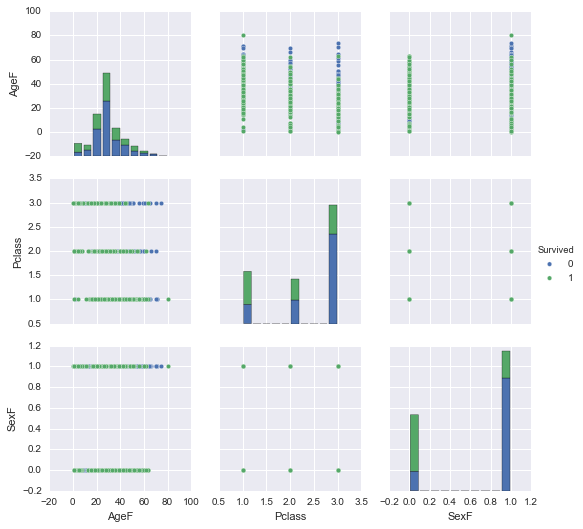

In [13]:
import seaborn as sns
sns.pairplot(train_data_munged, vars=["AgeF", "Pclass", "SexF"], hue="Survived", dropna=True)
sns.plt.show()

Beautiful, but such "class-floor" in the pair correlation is not very clear. We estimate the importance of our algorithms signs [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) .
wikipedia link:- [F-test](https://en.wikipedia.org/wiki/F-test).

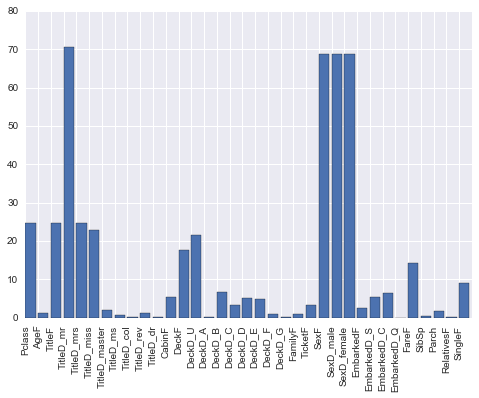

In [14]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=5)
selector.fit(train_data_munged[predictors], train_data_munged["Survived"])

scores = -np.log10(selector.pvalues_)

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

Before you begin to run a classification, we need to understand how we will evaluate it. In the case of Kaggle it is very simple: we just read their rules. 

In the case of the Titanic assessment will serve as the ratio of correct assessment of the classifier to the total number of passengers. 

In other words, this estimate is called the accuracy . But before you send the classification result on test-sample for evaluation in Kaggle, it would be nice to understand at least the approximate performance of our classifier.


<i>classifier.fit(train_X, train_y)</i>

<i>predict_y = classifier.predict(train_X)</i>

<i>return metrics.accuracy_score(train_y, predict_y)</i>

In [15]:
from sklearn.cross_validation import StratifiedKFold
cv = StratifiedKFold(train_data["Survived"], n_folds=3, shuffle=True, random_state=1)

Here we define a complex process: training data will be divided into three pieces, and the record will fall into each piece randomly (to neutralize the possible dependence of the order), also a strategy to track the ratio of classes were approximately equal in each piece. Thus we produce three measurements on pieces 1 + 2 vs 3, 1 + 3 vs 2, 2 + 3 vs 1 - thereafter can obtain an average estimate accuracy of the classifier (which will characterize the performance), and estimates the variance (which will to characterize the stability of his work).

## Classification

#### KNeighborsClassifier 

In [16]:
from sklearn.neighbors import KNeighborsClassifi
alg_ngbh = KNeighborsClassifier(n_neighbors=3)
scores = cross_validation.cross_val_score(alg_ngbh, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (k-neighbors): {}/{}".format(scores.mean(), scores.std()))

Accuracy (k-neighbors): 0.7957351290684623/0.011110544261068086


#### SGDClassifier

In [17]:
from sklearn.linear_model.stochastic_gradient import SGDClassifier
alg_sgd = SGDClassifier(random_state=1)
scores = cross_validation.cross_val_score(alg_sgd, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (sgd): {}/{}".format(scores.mean(), scores.std()))

Accuracy (sgd): 0.7239057239057239/0.015306601231185043


#### SVC

In [18]:
from sklearn.svm import SVC
alg_svm = SVC(C=1.0)
scores = cross_validation.cross_val_score(alg_svm, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (svm): {}/{}".format(scores.mean(), scores.std()))

Accuracy (svm): 0.8193041526374859/0.010408101566212916


#### GaussianNB

In [19]:
from sklearn.naive_bayes import GaussianNB
alg_nbs = GaussianNB()
scores = cross_validation.cross_val_score(alg_nbs, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (naive bayes): {}/{}".format(scores.mean(), scores.std()))

Accuracy (naive bayes): 0.6206509539842874/0.16339123708526998


#### LinearRegression

In [ ]:
def linear_scorer(estimator, x, y):
    scorer_predictions = estimator.predict(x)

    scorer_predictions[scorer_predictions > 0.5] = 1
    scorer_predictions[scorer_predictions <= 0.5] = 0

    return metrics.accuracy_score(y, scorer_predictions)


In [ ]:
from sklearn import linear_model
alg_lnr = linear_model.LinearRegression()
scores = cross_validation.cross_val_score(alg_lnr, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1,
                         scoring=linear_scorer)
print("Accuracy (linear regression): {}/{}".format(scores.mean(), scores.std()))


Linear_scorer method is needed because LinearRegression - this regression returning any real number. Accordingly, we share border 0.5 scale and give any of the two classes - 0 and 1.

In [ ]:

from sklearn import linear_model
alg_log = linear_model.LogisticRegression(random_state=1)
scores = cross_validation.cross_val_score(alg_log, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1,
                         scoring=linear_scorer)
print("Accuracy (logistic regression): {}/{}".format(scores.mean(), scores.std()))

In [20]:
from sklearn.ensemble import RandomForestClassifier
alg_frst = RandomForestClassifier(random_state=1, n_estimators=500, min_samples_split=8, min_samples_leaf=2)
scores = cross_validation.cross_val_score(alg_frst, train_data_scaled, train_data_munged["Survived"], cv=cv, n_jobs=-1)
print("Accuracy (random forest): {}/{}".format(scores.mean(), scores.std()))

Accuracy (random forest): 0.8294051627384961/0.004199391006480274


In [21]:
from sklearn.grid_search import GridSearchCV

alg_frst_model = RandomForestClassifier(random_state=1)
alg_frst_params = [{
    "n_estimators": [350, 400, 450],
    "min_samples_split": [6, 8, 10],
    "min_samples_leaf": [1, 2, 4]
}]
alg_frst_grid = GridSearchCV(alg_frst_model, alg_frst_params, cv=cv, refit=True, verbose=1, n_jobs=-1)
alg_frst_grid.fit(train_data_scaled, train_data_munged["Survived"])
alg_frst_best = alg_frst_grid.best_estimator_
print("Accuracy (random forest auto): {} with params {}"
      .format(alg_frst_grid.best_score_, alg_frst_grid.best_params_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   15.3s finished


Accuracy (random forest auto): 0.8372615039281706 with params {'min_samples_split': 6, 'min_samples_leaf': 4, 'n_estimators': 400}


In [22]:
alg_test = alg_frst_best

alg_test.fit(train_data_scaled, train_data_munged["Survived"])

predictions = alg_test.predict(test_data_scaled)

submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": predictions
})

submission.to_csv("titanic-submission.csv", index=False)

## 2. Way to predict survival on Titianic

These notes are from this [link](http://corpocrat.com/2014/08/29/tutorial-titanic-dataset-machine-learning-for-kaggle/)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\Titanic\train.csv",header=0)

In [3]:
#Lets take a look at the data format below
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


If you carefully observe the above summary of pandas, there are total 891 rows, Age shows only 714 (means missing), Embarked (2 missing) and Cabin missing a lot as well. Object data types are non-numeric so we have to find a way to encode them to numerical values. One such way is columnisation ie. factorize to the row values to column header.

#### Lets try to drop some of the columns which many not contribute 

In [4]:
cols = ['Name','Ticket','Cabin']
df = df.drop(cols,axis=1)

#### if we want we can drop all rows in the data 

In [5]:
#df = df.dropna()

Now you see the dataset is reduced to 712 rows from 891, which means we are wasting data. Machine learning models need data for training to perform well. So we preserve the data and make use of it as much as we can. 

Now we convert the Pclass, Sex, Embarked to columns in pandas and drop them after conversion.

In [6]:
dummies = []
cols = ['Pclass','Sex','Embarked']
for col in cols:
 dummies.append(pd.get_dummies(df[col]))

In [7]:
titanic_dummies = pd.concat(dummies, axis=1)

In [8]:
titanic_dummies.head(2)

,1,2,3,female,male,C,Q,S
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [9]:
#finally we concatenate to the original dataframe columnwise
df = pd.concat((df,titanic_dummies),axis=1)

Now that we converted Pclass, Sex, Embarked values into columns, we drop the redundant same columns from the dataframe

In [10]:
df = df.drop(['Pclass','Sex','Embarked'],axis=1)

In [11]:
#now look on the new dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
1              891 non-null float64
2              891 non-null float64
3              891 non-null float64
female         891 non-null float64
male           891 non-null float64
C              891 non-null float64
Q              891 non-null float64
S              891 non-null float64
dtypes: float64(10), int64(4)
memory usage: 97.5 KB


All is good, except age which has lots of missing values. Lets compute a median or interpolate() all the ages and fill those missing age values. Pandas has a nice interpolate() function that will replace all the missing NaNs to interpolated values.

In [12]:
df['Age'] = df['Age'].interpolate()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
1              891 non-null float64
2              891 non-null float64
3              891 non-null float64
female         891 non-null float64
male           891 non-null float64
C              891 non-null float64
Q              891 non-null float64
S              891 non-null float64
dtypes: float64(10), int64(4)
memory usage: 97.5 KB


### Machine Learning

X = Input set with 14 attributes

y =  Small y Output, in this case ‘Survived’

Now we convert our dataframe from pandas to numpy and we assign input and output

In [14]:
X = df.values
y = df['Survived'].values

##### X has still Survived values in it, which should not be there. So we drop in numpy column which is the 1st column.

In [15]:
X = np.delete(X,1,axis=1)

Now that we are ready with X and y, lets split the dataset for 70% Training and  30% test set using scikit cross validation

In [18]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

Lets start with simple Decision Tree Classifier machine learning algorithm and see how it goes

In [19]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.78731343283582089

Not bad it gives score of 78.73%.

If you peform a decision tree on dataset, the variable importances_ contains important information on what columns of data has large variances thus contributing to the decision. 

In [20]:
clf.feature_importances_

array([ 0.08944147,  0.11138782,  0.05743406,  0.02186072,  0.05721831,
        0.03783151,  0.        ,  0.10597366,  0.50209245,  0.        ,
        0.        ,  0.        ,  0.01676001])

This output shows that second element in array 0.111,  “Fare” has 11% importance, the last 5 shows 51% which is ‘Females’. Very interesting! yes the large number of survivors in titanic are women and children.

### Random Forests

In [21]:
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(n_estimators=100)
clf.fit (X_train, y_train)
clf.score (X_test, y_test)


0.81343283582089554

### Gradient boosting

In [22]:
clf = ensemble.GradientBoostingClassifier()
clf.fit (X_train, y_train)
clf.score (X_test, y_test)


0.81343283582089554

In [23]:
#Let not give up and play around fine tune this Gradient booster.
clf = ensemble.GradientBoostingClassifier(n_estimators=50)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.83208955223880599

## 3. Way to predict survival on Titianic

These notes are from this [link](http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html#Installation-procedure)

### I - Exploratory data analysis

We tweak the style of this notebook a little bit to have centered plots.

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
#Import the libraries

# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

pd.options.display.max_rows = 100

In [3]:
#Now let's start by loading the training set.
data = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\Titanic\train.csv")

In [4]:
#Pandas allows you to have a sneak peak at your data.
data.head(2)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
data.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
#The count variable shows that 177 values are missing in the Age column.
data['Age'].fillna(data['Age'].median(), inplace=True)

#### Let's now make some charts

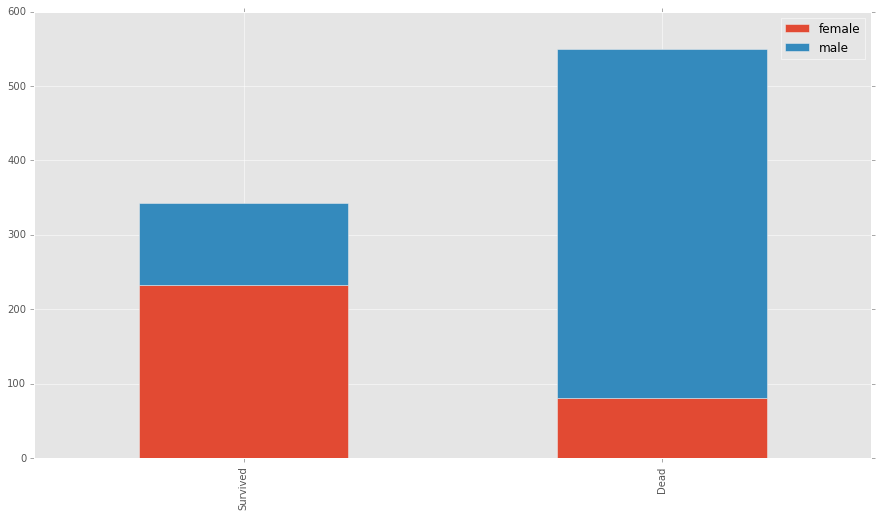

In [7]:
#Let's visualize survival based on the gender.
survived_sex = data[data['Survived']==1]['Sex'].value_counts()
dead_sex = data[data['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(15,8))

The Sex variable seems to be a decisive feature. Women are more likely to survive.

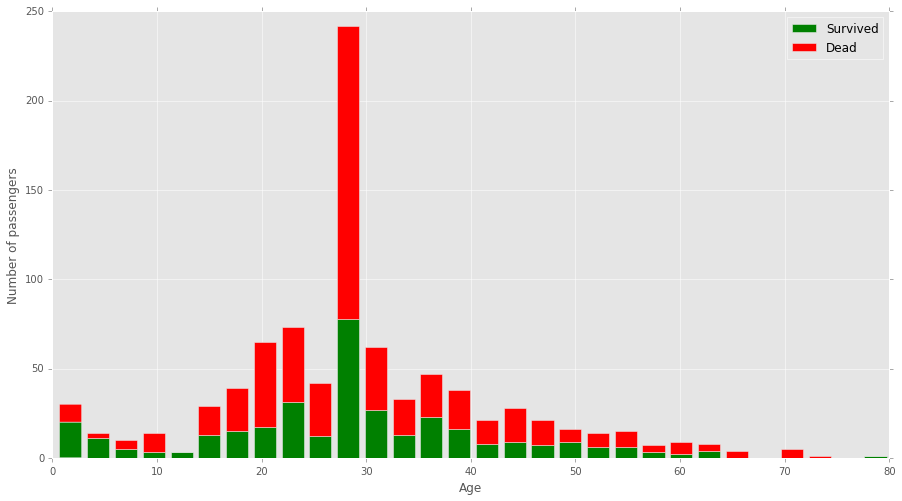

In [8]:
#Let's now correlate the survival with the age variable.
figure = plt.figure(figsize=(15,8))
plt.hist([data[data['Survived']==1]['Age'],data[data['Survived']==0]['Age']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

If you follow the chart bin by bin, you will notice that passengers who are less than 10 are more likely to survive than older ones who are more than 12 and less than 50. Older passengers seem to be rescued too.

These two first charts confirm that one old code of conduct that sailors and captains follow in case of threatening situations: "Women and children first !".

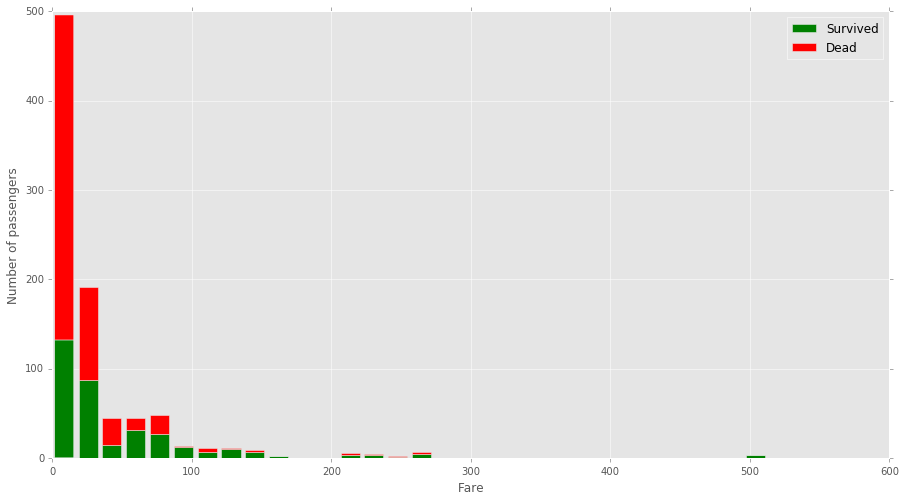

In [9]:
#Let's now focus on the Fare ticket of each passenger and correlate it with the survival.
figure = plt.figure(figsize=(15,8))
plt.hist([data[data['Survived']==1]['Fare'],data[data['Survived']==0]['Fare']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

Passengers with cheaper ticket fares are more likely to die. Put differently, passengers with more expensive tickets, and therefore a more important social status, seem to be rescued first.

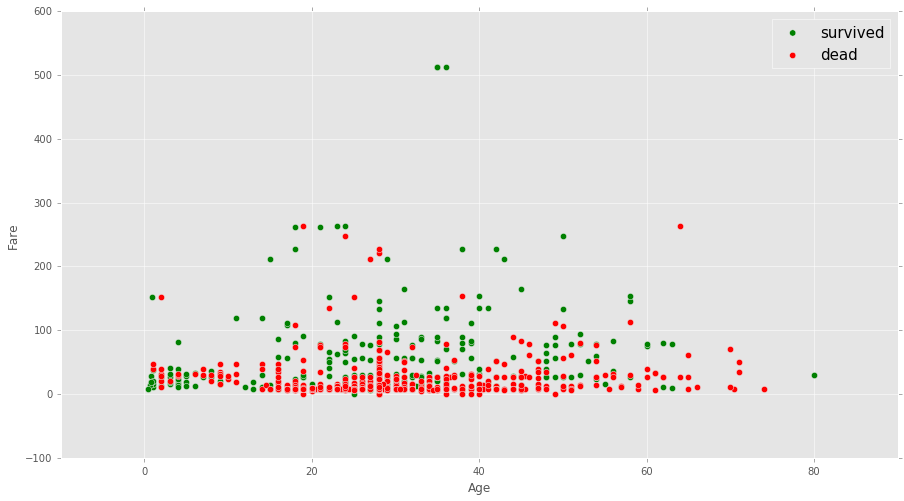

In [10]:
# Let's now combine the age, the fare and the survival on a single chart.
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.scatter(data[data['Survived']==1]['Age'],data[data['Survived']==1]['Fare'],c='green',s=40)
ax.scatter(data[data['Survived']==0]['Age'],data[data['Survived']==0]['Fare'],c='red',s=40)
ax.set_xlabel('Age')
ax.set_ylabel('Fare')
ax.legend(('survived','dead'),scatterpoints=1,loc='upper right',fontsize=15,)

A distinct cluster of dead passengers (the red one) appears on the chart. Those people are adults (age between 15 and 50) of lower class (lowest ticket fares).

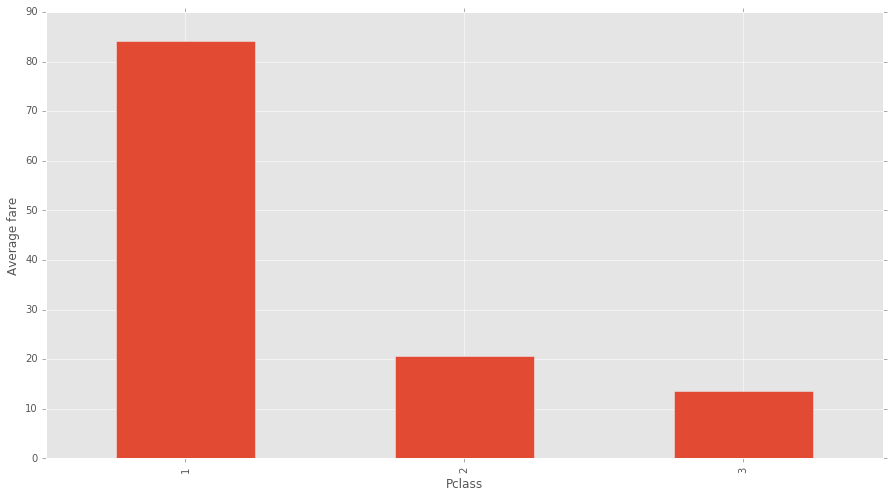

In [11]:
#the ticket fare correlates with the class as we see it in the chart below.
ax = plt.subplot()
ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar',figsize=(15,8), ax = ax)

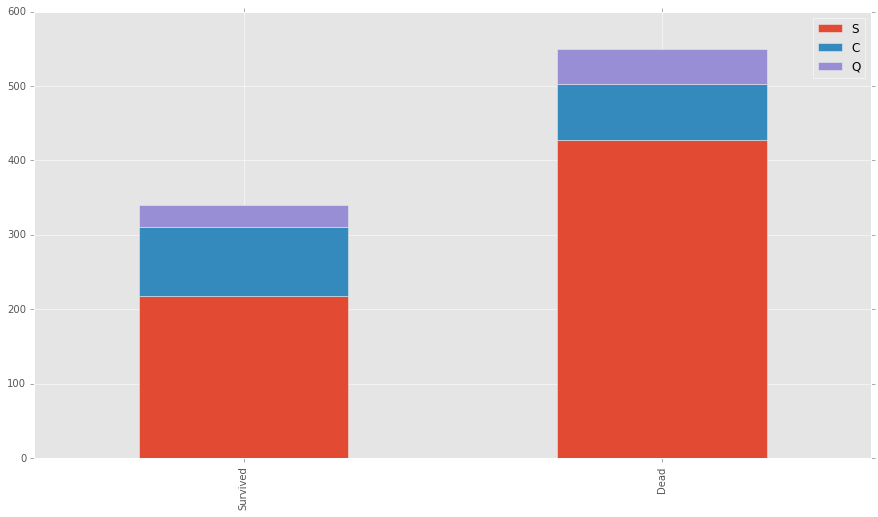

In [12]:
#Let's now see how the embarkation site affects the survival.
survived_embark = data[data['Survived']==1]['Embarked'].value_counts()
dead_embark = data[data['Survived']==0]['Embarked'].value_counts()
df = pd.DataFrame([survived_embark,dead_embark])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(15,8))

There seems to be no distinct correlation here.

### II - Feature engineering

In [14]:
#let's define a print function that asserts whether or not a feature has been processed.
def status(feature):
    print ('Processing',feature,': ok')

#### Loading the data
One trick when starting a machine learning problem is to combine the training set and the test set together. This is a useful technique especially when your test set appears to have a feature that doesn't exist in the training set. Therefore, if we don't combine the two sets, testing our model on the test set will dramatically fail.

Besides, combining the two sets will save us some repeated work to do later on when testing.

The procedure is quite simple.

* We start by loading the train set and the test set.
* We create an empty dataframe called combined.
* Then we append test to train and affect the result to combined.

In [15]:
def get_combined_data():
    # reading train data
    train = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\Titanic\train.csv")
    
    # reading test data
    test = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\Titanic\test.csv")

    # extracting and then removing the targets from the training data 
    targets = train.Survived
    train.drop('Survived',1,inplace=True)
    

    # merging train data and test data for future feature engineering
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop('index',inplace=True,axis=1)
    
    return combined

In [16]:
combined = get_combined_data()

In [17]:
combined.shape

(1309, 11)

You may notice that the total number of rows (1309) is the exact summation of the number of rows in the train set and the test set.

#### Extracting the passenger titles

In [18]:
def get_titles():

    global combined
    
    # we extract the title from each name
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated titles
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
    
    # we map each title
    combined['Title'] = combined.Title.map(Title_Dictionary)

In [19]:
get_titles()

In [21]:
combined.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs


#### Processing the ages

Simply replacing them with the mean or the median age might not be the best solution since the age may differ by groups and categories of passengers.

To understand why, let's group our dataset by sex, Title and passenger class and for each subset compute the median age.

In [22]:
grouped = combined.groupby(['Sex','Pclass','Title'])
grouped.median()


PassengerId   Age  SibSp  Parch      Fare
Sex    Pclass Title                                             
female 1      Miss           529.5  30.0    0.0    0.0   99.9625
              Mrs            853.5  45.0    1.0    0.0   78.1125
              Officer        797.0  49.0    0.0    0.0   25.9292
              Royalty        760.0  39.0    0.0    0.0   86.5000
       2      Miss           606.5  20.0    0.0    0.0   20.2500
              Mrs            533.0  30.0    1.0    0.0   26.0000
       3      Miss           603.5  18.0    0.0    0.0    8.0500
              Mrs            668.5  31.0    1.0    1.0   15.5000
male   1      Master         803.0   6.0    1.0    2.0  134.5000
              Mr             634.0  41.5    0.0    0.0   47.1000
              Officer        678.0  52.0    0.0    0.0   37.5500
              Royalty        600.0  40.0    0.0    0.0   27.7208
       2      Master         550.0   2.0    1.0    1.0   26.0000
              Mr             723.5  30.0    0.0    0.0   13.0000
              Officer        513.0  41.5    0.0    0.0   13.0000
       3      Master         789.0   6.0    3.0    1.0   22.3583
              Mr             640.5  26.0    0.0    0.0    7.8958

Look at the median age column and see how this value can be different based on the Sex, Pclass and Title put together.

For example:
* If the passenger is female, from Pclass 1, and from royalty the median age is 39.
* If the passenger is male, from Pclass 3, with a Mr title, the median age is 26.

In [23]:
def process_age():
    
    global combined
    
    # a function that fills the missing values of the Age variable
    
    def fillAges(row):
        if row['Sex']=='female' and row['Pclass'] == 1:
            if row['Title'] == 'Miss':
                return 30
            elif row['Title'] == 'Mrs':
                return 45
            elif row['Title'] == 'Officer':
                return 49
            elif row['Title'] == 'Royalty':
                return 39

        elif row['Sex']=='female' and row['Pclass'] == 2:
            if row['Title'] == 'Miss':
                return 20
            elif row['Title'] == 'Mrs':
                return 30

        elif row['Sex']=='female' and row['Pclass'] == 3:
            if row['Title'] == 'Miss':
                return 18
            elif row['Title'] == 'Mrs':
                return 31

        elif row['Sex']=='male' and row['Pclass'] == 1:
            if row['Title'] == 'Master':
                return 6
            elif row['Title'] == 'Mr':
                return 41.5
            elif row['Title'] == 'Officer':
                return 52
            elif row['Title'] == 'Royalty':
                return 40

        elif row['Sex']=='male' and row['Pclass'] == 2:
            if row['Title'] == 'Master':
                return 2
            elif row['Title'] == 'Mr':
                return 30
            elif row['Title'] == 'Officer':
                return 41.5

        elif row['Sex']=='male' and row['Pclass'] == 3:
            if row['Title'] == 'Master':
                return 6
            elif row['Title'] == 'Mr':
                return 26
    
    combined.Age = combined.apply(lambda r : fillAges(r) if np.isnan(r['Age']) else r['Age'], axis=1)
    
    status('age')

In [24]:
process_age()

Processing age : ok


In [25]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Title          1309 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 122.8+ KB


In [26]:
#Let's now process the names.
def process_names():
    
    global combined
    # we clean the Name variable
    combined.drop('Name',axis=1,inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(combined['Title'],prefix='Title')
    combined = pd.concat([combined,titles_dummies],axis=1)
    
    # removing the title variable
    combined.drop('Title',axis=1,inplace=True)
    
    status('names')

This function drops the Name column since we won't be using it anymore because we created a Title column.

Then we encode the title values using a dummy encoding.

In [27]:
process_names()

Processing names : ok


In [28]:
combined.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,1.0,0.0,0.0,0.0
1,2,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0.0,0.0,0.0,1.0,0.0,0.0
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,1.0,0.0,0.0,0.0,0.0
3,4,1,female,35.0,1,0,113803,53.1000,C123,S,0.0,0.0,0.0,1.0,0.0,0.0
4,5,3,male,35.0,0,0,373450,8.0500,NaN,S,0.0,0.0,1.0,0.0,0.0,0.0


As you can see :
* there is no longer a name feature.
* new variables (Title_X) appeared. These features are binary.
    * For example, If Title_Mr = 1, the corresponding Title is Mr.

#### Processing Fare

In [30]:
#This function simply replaces one missing Fare value by the mean.
def process_fares():
    
    global combined
    # there's one missing fare value - replacing it with the mean.
    combined.Fare.fillna(combined.Fare.mean(),inplace=True)
    
    status('fare')

In [31]:
process_fares()

Processing fare : ok


#### Processing Embarked

In [32]:
#This functions replaces the two missing values of Embarked with the most frequent Embarked value.
def process_embarked():
    
    global combined
    # two missing embarked values - filling them with the most frequent one (S)
    combined.Embarked.fillna('S',inplace=True)
    
    # dummy encoding 
    embarked_dummies = pd.get_dummies(combined['Embarked'],prefix='Embarked')
    combined = pd.concat([combined,embarked_dummies],axis=1)
    combined.drop('Embarked',axis=1,inplace=True)
    
    status('embarked')

In [33]:
process_embarked()

Processing embarked : ok


#### Processing Cabin

In [34]:
#This function replaces NaN values with U (for Unknow). It then maps each Cabin value to the first letter. Then it encodes the cabin values using dummy encoding again.
def process_cabin():
    
    global combined
    
    # replacing missing cabins with U (for Uknown)
    combined.Cabin.fillna('U',inplace=True)
    
    # mapping each Cabin value with the cabin letter
    combined['Cabin'] = combined['Cabin'].map(lambda c : c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(combined['Cabin'],prefix='Cabin')
    
    combined = pd.concat([combined,cabin_dummies],axis=1)
    
    combined.drop('Cabin',axis=1,inplace=True)
    
    status('cabin')

In [35]:
process_cabin()

Processing cabin : ok


In [36]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 26 columns):
PassengerId      1309 non-null int64
Pclass           1309 non-null int64
Sex              1309 non-null object
Age              1309 non-null float64
SibSp            1309 non-null int64
Parch            1309 non-null int64
Ticket           1309 non-null object
Fare             1309 non-null float64
Title_Master     1309 non-null float64
Title_Miss       1309 non-null float64
Title_Mr         1309 non-null float64
Title_Mrs        1309 non-null float64
Title_Officer    1309 non-null float64
Title_Royalty    1309 non-null float64
Embarked_C       1309 non-null float64
Embarked_Q       1309 non-null float64
Embarked_S       1309 non-null float64
Cabin_A          1309 non-null float64
Cabin_B          1309 non-null float64
Cabin_C          1309 non-null float64
Cabin_D          1309 non-null float64
Cabin_E          1309 non-null float64
Cabin_F          1309 non-null float64
Cabin_

##### Ok no missing values now.

#### Processing Sex

In [37]:
#This function maps the string values male and female to 1 and 0 respectively.
def process_sex():
    
    global combined
    # mapping string values to numerical one 
    combined['Sex'] = combined['Sex'].map({'male':1,'female':0})
    
    status('sex')

In [38]:
process_sex()

Processing sex : ok


#### Processing Pclass

In [39]:
#This function encodes the values of Pclass (1,2,3) using a dummy encoding.
def process_pclass():
    
    global combined
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'],prefix="Pclass")
    
    # adding dummy variables
    combined = pd.concat([combined,pclass_dummies],axis=1)
    
    # removing "Pclass"
    
    combined.drop('Pclass',axis=1,inplace=True)
    
    status('pclass')

In [40]:
process_pclass()

Processing pclass : ok


* This functions preprocess the tikets first by extracting the ticket prefix. When it fails in extracting a prefix it returns XXX.
* Then it encodes prefixes using dummy encoding.

In [47]:
def process_ticket():
    
    global combined
    
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip() , ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

    # Extracting dummy variables from tickets:

    combined['Ticket'] = combined['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined['Ticket'],prefix='Ticket')
    combined = pd.concat([combined, tickets_dummies],axis=1)
    combined.drop('Ticket',inplace=True,axis=1)

    status('ticket')

In [48]:
process_ticket()

Processing ticket : ok


This function introduces 4 new features:
* FamilySize : the total number of relatives including the passenger (him/her)self.
* Sigleton : a boolean variable that describes families of size = 1
* SmallFamily : a boolean variable that describes families of 2 <= size <= 4
* LargeFamily : a boolean variable that describes families of 5 < size

In [49]:
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s : 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s : 1 if 2<=s<=4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s : 1 if 5<=s else 0)
    
    status('family')

In [50]:
process_family()

Processing family : ok


In [51]:
combined.shape


(1309, 68)

In [52]:
#Let's normalize all of them in the unit interval. 
#All of them except the PassengerId that we'll need for the submission.
def scale_all_features():
    
    global combined
    
    features = list(combined.columns)
    features.remove('PassengerId')
    combined[features] = combined[features].apply(lambda x: x/x.max(), axis=0)
    
    print ('Features scaled successfully !')

### III - Modeling

We now have to:
1. Break the combined dataset in train set and test set.
2. Use the train set to build a predictive model.
3. Evaluate the model using the train set.
4. Test the model using the test set and generate and output file for the submission.

http://www.overkillanalytics.net/more-is-always-better-the-power-of-simple-ensembles/

In [53]:
#Let's start by importing the useful libraries.

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score

In [54]:
#To evaluate our model we'll be using a 5-fold cross validation with the Accuracy metric.
def compute_score(clf, X, y,scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5,scoring=scoring)
    return np.mean(xval)


In [55]:
#Recover the train set and the test set from the combined dataset
def recover_train_test_target():
    global combined
    
    train0 = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\Titanic\train.csv")
    
    targets = train0.Survived
    train = combined.ix[0:890]
    test = combined.ix[891:]
    
    return train,test,targets

In [56]:
train,test,targets = recover_train_test_target()


### Feature selection

In [57]:
#Tree-based estimators can be used to compute feature importances, which in turn can be used to discard irrelevant features.
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(train, targets)

In [58]:
#Let's have a look at the importance of each feature.
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_

In [59]:
features.sort(['importance'],ascending=False)

,feature,importance
0,PassengerId,0.130185
2,Age,0.117193
5,Fare,0.112109
8,Title_Mr,0.111754
1,Sex,0.107180
7,Title_Miss,0.042467
26,Pclass_3,0.038323
9,Title_Mrs,0.031687
23,Cabin_U,0.029953
24,Pclass_1,0.022660


As you may notice, there is a great importance linked to Title_Mr, Age, Fare, and Sex.

There is also an important correlation with the Passenger_Id.`

In [60]:
#Let's now transform our train set and test set in a more compact datasets.
model = SelectFromModel(clf, prefit=True)
train_new = model.transform(train)
train_new.shape

(891, 15)

In [61]:
test_new = model.transform(test)
test_new.shape

(418, 15)

### Hyperparameters tuning

In [63]:
#Random Forest are quite handy. They do however come with some parameters to tweak in order to get an optimal model for the prediction task.
forest = RandomForestClassifier(max_features='sqrt')

parameter_grid = {
                 'max_depth' : [4,5,6,7,8],
                 'n_estimators': [200,210,240,250],
                 'criterion': ['gini','entropy']
                 }

cross_validation = StratifiedKFold(targets, n_folds=5)

grid_search = GridSearchCV(forest,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_new, targets)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8316498316498316
Best parameters: {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 250}


In [64]:
output = grid_search.predict(test_new).astype(int)
df_output = pd.DataFrame()
df_output['PassengerId'] = test['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('output.csv',index=False)

### Your submission scored 0.78947

# 4. Way to predict survival on Titianic

These notes are taken from this [link](http://nbviewer.jupyter.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm


In [3]:
#Not working at the moment
import sys
sys.path.append(r'C:\Users\piush\Desktop\Dataset\KaggleAux')
#from KaggleAux import predict as ka # see github.com/agconti/kaggleaux for more details

### Data Handling

In [4]:
df = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\Titanic\train.csv")

In [5]:
#Take care of missing values:
df = df.drop(['Ticket','Cabin'], axis=1) 
# Remove NaN values
df = df.dropna() 

[Link](https://bitbucket.org/hrojas/learn-pandas) to learn pandas

### Let's take a Look at our data graphically:

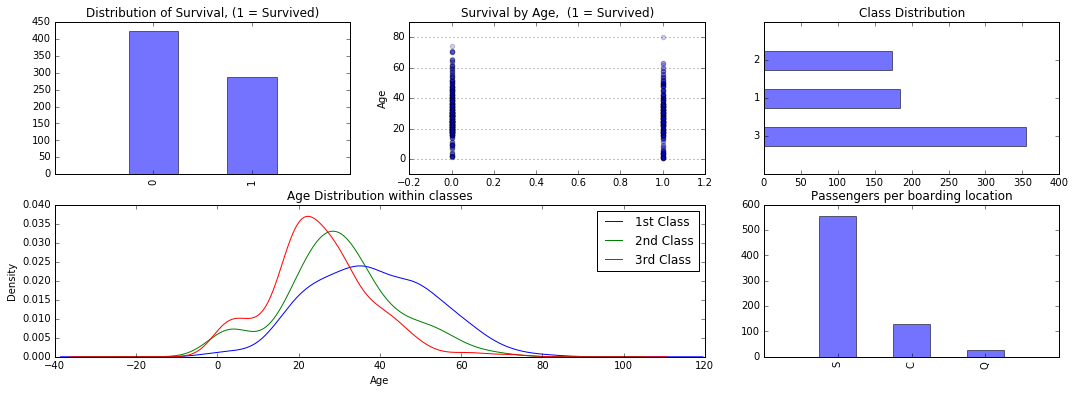

In [6]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Distribution of Survival, (1 = Survived)")    

plt.subplot2grid((2,3),(0,1))
plt.scatter(df.Survived, df.Age, alpha=alpha_scatterplot)
# sets the y axis lable
plt.ylabel("Age")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Survival by Age,  (1 = Survived)")

ax3 = plt.subplot2grid((2,3),(0,2))
df.Pclass.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax3.set_ylim(-1, len(df.Pclass.value_counts()))
plt.title("Class Distribution")

plt.subplot2grid((2,3),(1,0), colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
df.Age[df.Pclass == 1].plot(kind='kde')    
df.Age[df.Pclass == 2].plot(kind='kde')
df.Age[df.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

ax5 = plt.subplot2grid((2,3),(1,2))
df.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax5.set_xlim(-1, len(df.Embarked.value_counts()))
# specifies the parameters of our graphs
plt.title("Passengers per boarding location")

### Exploratory Visualization:

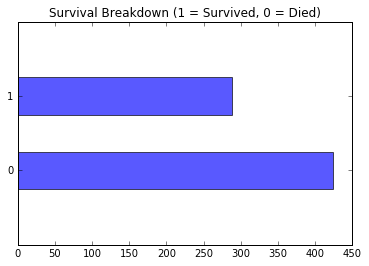

In [7]:
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
df.Survived.value_counts().plot(kind='barh', color="blue", alpha=.65)
ax.set_ylim(-1, len(df.Survived.value_counts())) 
plt.title("Survival Breakdown (1 = Survived, 0 = Died)")

(-1, 2)

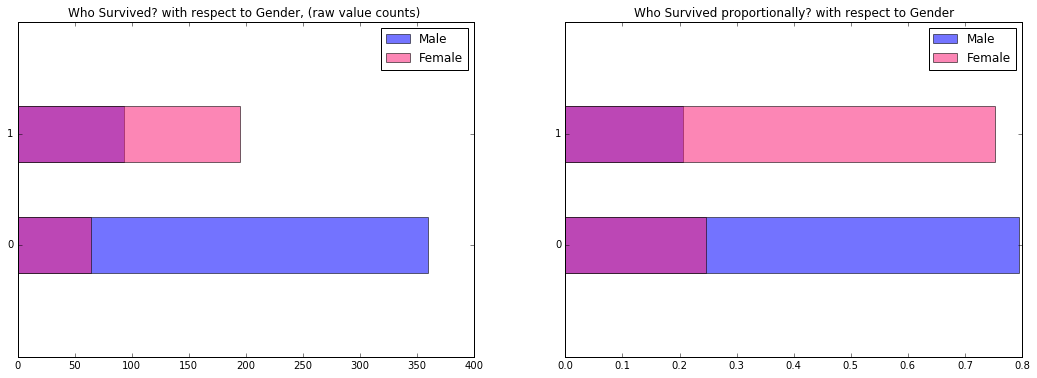

In [8]:
#Let’s break the previous graph down by gender
fig = plt.figure(figsize=(18,6))

#create a plot of two subsets, male and female, of the survived variable.
#After we do that we call value_counts() so it can be easily plotted as a bar graph. 
#'barh' is just a horizontal bar graph
df_male = df.Survived[df.Sex == 'male'].value_counts().sort_index()
df_female = df.Survived[df.Sex == 'female'].value_counts().sort_index()

ax1 = fig.add_subplot(121)
df_male.plot(kind='barh',label='Male', alpha=0.55)
df_female.plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived? with respect to Gender, (raw value counts) "); plt.legend(loc='best')
ax1.set_ylim(-1, 2) 

#adjust graph to display the proportions of survival by gender
ax2 = fig.add_subplot(122)
(df_male/float(df_male.sum())).plot(kind='barh',label='Male', alpha=0.55)  
(df_female/float(df_female.sum())).plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived proportionally? with respect to Gender"); plt.legend(loc='best')

ax2.set_ylim(-1, 2)

Can we capture more of the structure by using Pclass? Here we will bucket classes as lowest class or any of the high classes (classes 1 - 2). 3 is lowest class. Let’s break it down by Gender and what Class they were traveling in.

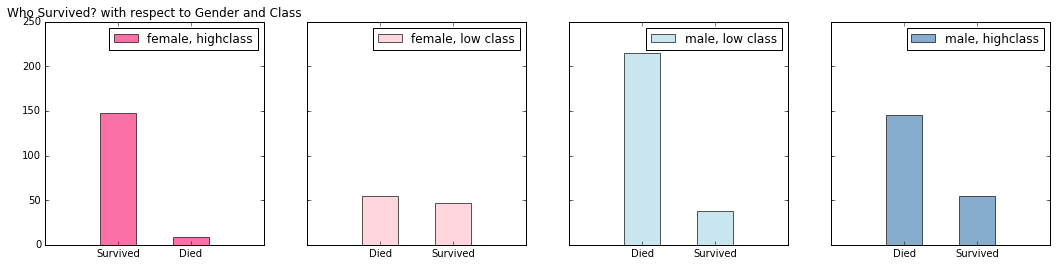

In [9]:
fig = plt.figure(figsize=(18,4), dpi=1600)
alpha_level = 0.65

# building on the previous code, here we create an additional subset with in the gender subset 
# we created for the survived variable. I know, thats a lot of subsets. After we do that we call 
# value_counts() so it it can be easily plotted as a bar graph. this is repeated for each gender 
# class pair.
ax1=fig.add_subplot(141)
female_highclass = df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()
female_highclass.plot(kind='bar', label='female, highclass', color='#FA2479', alpha=alpha_level)
ax1.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
female_lowclass = df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()
female_lowclass.plot(kind='bar', label='female, low class', color='pink', alpha=alpha_level)
ax2.set_xticklabels(["Died","Survived"], rotation=0)
ax2.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
male_lowclass = df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()
male_lowclass.plot(kind='bar', label='male, low class',color='lightblue', alpha=alpha_level)
ax3.set_xticklabels(["Died","Survived"], rotation=0)
ax3.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
male_highclass = df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()
male_highclass.plot(kind='bar', label='male, highclass', alpha=alpha_level, color='steelblue')
ax4.set_xticklabels(["Died","Survived"], rotation=0)
ax4.set_xlim(-1, len(male_highclass))
plt.legend(loc='best')

### Supervised Machine Learning

First, we define our formula for our Logit regression. In the next cell we create a regression friendly dataframe that sets up boolean values for the categorical variables in our formula and lets our regression model know the types of inputs we're giving it. The model is then instantiated and fitted before a summary of the model's performance is printed. In the last cell we graphically compare the predictions of our model to the actual values we are trying to predict, as well as the residual errors from our model to check for any structure we may have missed.

In [11]:
# model formula
# here the ~ sign is an = sign, and the features of our dataset
# are written as a formula to predict survived. The C() lets our 
# regression know that those variables are categorical.
# Ref: http://patsy.readthedocs.org/en/latest/formulas.html
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp  + C(Embarked)' 
# create a results dictionary to hold our regression results for easy analysis later        
results = {} 



In [12]:
# create a regression friendly dataframe using patsy's dmatrices function
y,x = dmatrices(formula, data=df, return_type='dataframe')

# instantiate our model
model = sm.Logit(y,x)

# fit our model to the training data
res = model.fit()

# save the result for outputing predictions later
results['Logit'] = [res, formula]
res.summary()

Optimization terminated successfully.
         Current function value: 0.444388
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Sat, 20 Aug 2016   Pseudo R-squ.:                  0.3414
Time:                        16:37:45   Log-Likelihood:                -316.40
converged:                       True   LL-Null:                       -480.45
                                        LLR p-value:                 5.992e-67
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            4.5423      0.474      9.583      0.000         3.613     5.471
C(Pclass)[T.2]      -1.2673      0.299     -4.245      0.000        -1.852    -0.682
C(Pclass)[T.3]      -2.4966      0.296     -8.422      0.000        -3.078    -1.916
C(Sex)[T.male]      -2.6239      0.218    -12.060      0.000        -3.050    -2.197
C(Embarked)[T.Q]    -0.8351      0.597     -1.398      0.162        -2.006     0.335
C(Embarked)[T.S]    -0.4254      0.271     -1.572      0.116        -0.956     0.105
Age                 -0.0436      0.008     -5.264      0.000        -0.060    -0.027
SibSp               -0.3697      0.123     -3.004      0.003        -0.611    -0.129
====================================================================================
"""

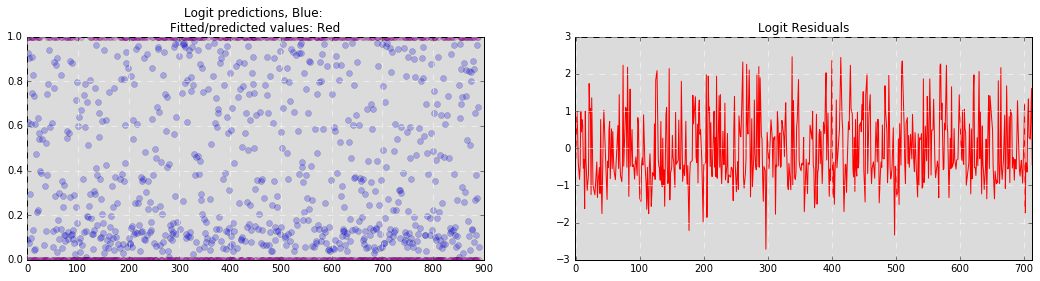

In [13]:
# Plot Predictions Vs Actual
plt.figure(figsize=(18,4));
plt.subplot(121, axisbg="#DBDBDB")
# generate predictions from our fitted model
ypred = res.predict(x)
plt.plot(x.index, ypred, 'bo', x.index, y, 'mo', alpha=.25);
plt.grid(color='white', linestyle='dashed')
plt.title('Logit predictions, Blue: \nFitted/predicted values: Red');

# Residuals
ax2 = plt.subplot(122, axisbg="#DBDBDB")
plt.plot(res.resid_dev, 'r-')
plt.grid(color='white', linestyle='dashed')
ax2.set_xlim(-1, len(res.resid_dev))
plt.title('Logit Residuals');

### How well did this work?

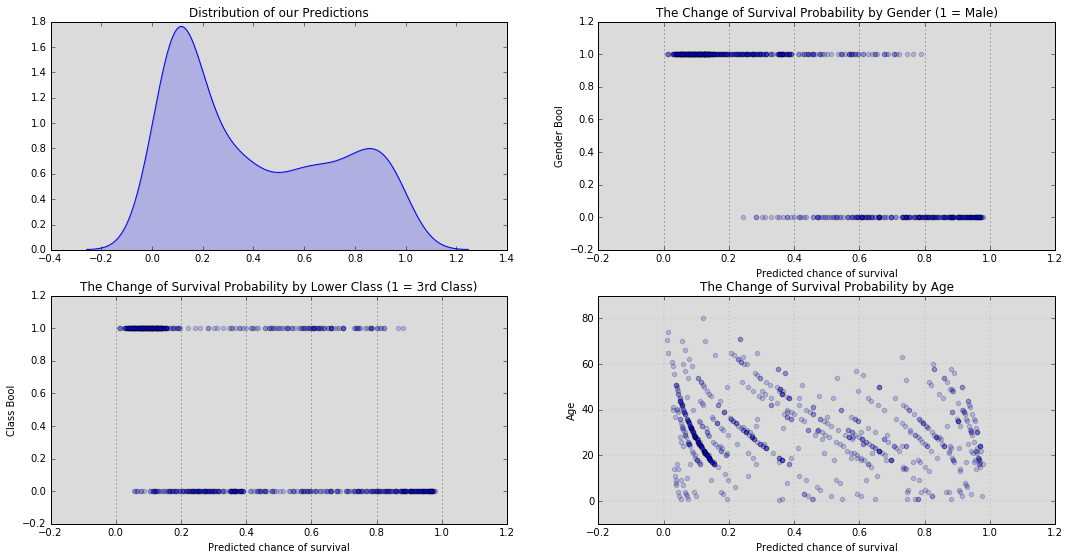

In [14]:
fig = plt.figure(figsize=(18,9), dpi=1600)
a = .2

# Below are examples of more advanced plotting. 
# It it looks strange check out the tutorial above.
fig.add_subplot(221, axisbg="#DBDBDB")
kde_res = KDEUnivariate(res.predict())
kde_res.fit()
plt.plot(kde_res.support,kde_res.density)
plt.fill_between(kde_res.support,kde_res.density, alpha=a)
plt.title("Distribution of our Predictions")

fig.add_subplot(222, axisbg="#DBDBDB")
plt.scatter(res.predict(),x['C(Sex)[T.male]'] , alpha=a)
plt.grid(b=True, which='major', axis='x')
plt.xlabel("Predicted chance of survival")
plt.ylabel("Gender Bool")
plt.title("The Change of Survival Probability by Gender (1 = Male)")

fig.add_subplot(223, axisbg="#DBDBDB")
plt.scatter(res.predict(),x['C(Pclass)[T.3]'] , alpha=a)
plt.xlabel("Predicted chance of survival")
plt.ylabel("Class Bool")
plt.grid(b=True, which='major', axis='x')
plt.title("The Change of Survival Probability by Lower Class (1 = 3rd Class)")

fig.add_subplot(224, axisbg="#DBDBDB")
plt.scatter(res.predict(),x.Age , alpha=a)
plt.grid(True, linewidth=0.15)
plt.title("The Change of Survival Probability by Age")
plt.xlabel("Predicted chance of survival")
plt.ylabel("Age")

##### Now lets use our model to predict the test set values and then save the results so they can be outputed to Kaggle

In [15]:
test_data = pd.read_csv(r"C:\Users\piush\Desktop\Dataset\Titanic\test.csv")

#### Add our independent variable to our test data. (It is usually left blank by Kaggle because it is the value you are trying to predict.)

In [17]:
test_data['Survived'] = 1.23


In [18]:
#Our binned results data:
results 

{'Logit': [<statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x26b002c6da0>,
  'Survived ~ C(Pclass) + C(Sex) + Age + SibSp  + C(Embarked)']}

In [27]:
# Use your model to make prediction on our test set. 
#compared_resuts = predict(test_data, results, 'Logit')
#compared_resuts = Series(compared_resuts)  # convert our model to a series for easy output

In [22]:
# output and submit to kaggle
#compared_resuts.to_csv("data/output/logitregres.csv")

In [28]:
# Create an acceptable formula for our machine learning algorithms
formula_ml = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Embarked)'

### Support Vector Machines

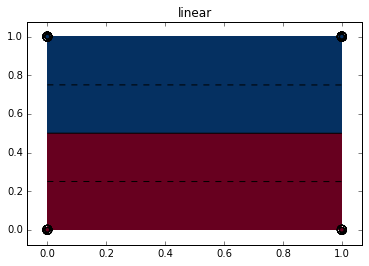

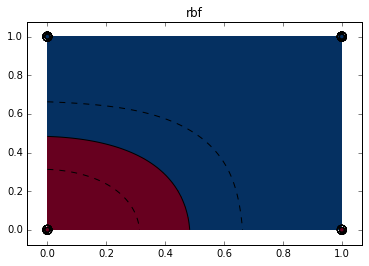

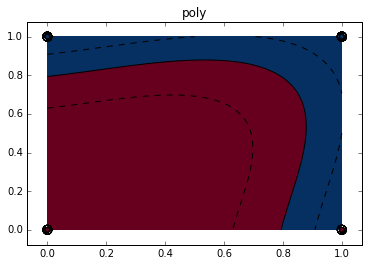

In [29]:
# set plotting parameters
plt.figure(figsize=(8,6))

# create a regression friendly data frame
y, x = dmatrices(formula_ml, data=df, return_type='matrix')

# select which features we would like to analyze
# try chaning the selection here for diffrent output.
# Choose : [2,3] - pretty sweet DBs [3,1] --standard DBs [7,3] -very cool DBs,
# [3,6] -- very long complex dbs, could take over an hour to calculate! 
feature_1 = 2
feature_2 = 3

X = np.asarray(x)
X = X[:,[feature_1, feature_2]]  


y = np.asarray(y)
# needs to be 1 dimenstional so we flatten. it comes out of dmatirces with a shape. 
y = y.flatten()      

n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)

X = X[order]
y = y[order].astype(np.float)

# do a cross validation
nighty_precent_of_sample = int(.9 * n_sample)
X_train = X[:nighty_precent_of_sample]
y_train = y[:nighty_precent_of_sample]
X_test = X[nighty_precent_of_sample:]
y_test = y[nighty_precent_of_sample:]

# create a list of the types of kerneks we will use for your analysis
types_of_kernels = ['linear', 'rbf', 'poly']

# specify our color map for plotting the results
color_map = plt.cm.RdBu_r

# fit the model
for fig_num, kernel in enumerate(types_of_kernels):
    clf = svm.SVC(kernel=kernel, gamma=3)
    clf.fit(X_train, y_train)

    plt.figure(fig_num)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=color_map)

    # circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10)
    
    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=color_map)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
               levels=[-.5, 0, .5])

    plt.title(kernel)
    plt.show()


Any value in the blue survived while anyone in the read did not. Checkout the graph for the linear transformation. It created its decision boundary right on 50%! That guess from earlier turned out to be pretty good. As you can see, the remaining decision boundaries are much more complex than our original linear decision boundary. These more complex boundaries may be able to capture more structure in the dataset, if that structure exists, and so might create a more powerful predictive model.

In [30]:
# Here you can output which ever result you would like by changing the Kernel and clf.predict lines
# Change kernel here to poly, rbf or linear
# adjusting the gamma level also changes the degree to which the model is fitted
clf = svm.SVC(kernel='poly', gamma=3).fit(X_train, y_train)                                                            
y,x = dmatrices(formula_ml, data=test_data, return_type='dataframe')

# Change the interger values within x.ix[:,[6,3]].dropna() explore the relationships between other 
# features. the ints are column postions. ie. [6,3] 6th column and the third column are evaluated. 
res_svm = clf.predict(x.ix[:,[6,3]].dropna()) 

res_svm = DataFrame(res_svm,columns=['Survived'])
res_svm.to_csv("svm_poly_63_g10.csv") # saves the results for you, change the name as you please. 

#### Random Forest

In [32]:
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske

# Create the random forest model and fit the model to our training data
y, x = dmatrices(formula_ml, data=df, return_type='dataframe')
# RandomForestClassifier expects a 1 demensional NumPy array, so we convert
y = np.asarray(y).ravel()
#instantiate and fit our model
results_rf = ske.RandomForestClassifier(n_estimators=100).fit(x, y)

# Score the results
score = results_rf.score(x, y)
print ("Mean accuracy of Random Forest Predictions on the data was: {0}".format(score))

Mean accuracy of Random Forest Predictions on the data was: 0.9452247191011236
